In [249]:
# importieren der Basic Libaries
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML
tex = '/content/charging_data.csv'
import seaborn as sns
ds = pd.read_csv(tex)

<ipython-input-249-3bf87887b2c0>:12: DtypeWarning: Columns (4,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  ds = pd.read_csv(tex)


In [250]:
# Berechnet Kalenderwochennummer ab 2005
def print_year_category(year):
    return max(0, 52 * (year - 2005))

In [251]:
# Entferne die unnötigen Spalten
ds_clean = ds.drop(columns=['adresszusatz','postleitzahl','betreiber','art_der_ladeeinrichung','anzahl_ladepunkte','anschlussleistung','steckertypen1','steckertypen2','steckertypen3','steckertypen4',
                            'p1_kw','p2_kw','p3_kw','p4_kw','kreis_kreisfreie_stadt','ort','strasse','hausnummer','breitengrad','laengengrad;;'])

# Entferne alle Zeilen mit fehlenden Werten
ds_clean = ds_clean.dropna()

# Konvertiere die Spalte 'inbetriebnahmedatum' im Datetime-Format
ds_clean['inbetriebnahmedatum'] = pd.to_datetime(ds_clean['inbetriebnahmedatum'], errors='coerce')

# Erstelle eine neue Spalte mit dem Jahr
ds_clean['jahr'] = ds_clean['inbetriebnahmedatum'].dt.year

# Erstelle eine neue Spalte mit der Kalenderwoche
ds_clean['kalenderwoche'] = ds_clean['inbetriebnahmedatum'].dt.isocalendar().week

# Filtere Zeilen vor dem Jahr 2005
ds_clean = ds_clean[ds_clean['jahr'] >= 2005]

# Erstelle eine neue Spalte, die die Kalenderwochen von unten aufsteigend durchnummeriert
ds_clean['KalNum'] = ds_clean['jahr'].apply(print_year_category) + ds_clean['kalenderwoche']

# Sortiere das DataFrame nach 'inbetriebnahmedatum'
ds_clean = ds_clean.sort_values(by='inbetriebnahmedatum')

<ipython-input-251-8f38cfa61c25>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_clean['inbetriebnahmedatum'] = pd.to_datetime(ds_clean['inbetriebnahmedatum'], errors='coerce')
<ipython-input-251-8f38cfa61c25>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_clean['jahr'] = ds_clean['inbetriebnahmedatum'].dt.year
<ipython-input-251-8f38cfa61c25>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [252]:
# Gruppiere den DataFrame nach der Spalte 'KalNum' und zähle die Anzahl der Einträge pro Gruppe
grouped_data = ds_clean.groupby('KalNum').size().reset_index(name='Anzahl')

# Erstelle eine neue Tabelle mit den Spalten 'KalNum' und 'Anzahl'
neue_tabelle = pd.DataFrame({'Anzahl': grouped_data['Anzahl']})

# Zeige die neue Tabelle an
neue_tabelle.tail()

,Anzahl
629,116
630,112
631,79
632,43
633,62


In [253]:
# Zuweisung 100% der Daten in Trainingsdaten
trainingds = neue_tabelle[:len(neue_tabelle)]
Trainingsdaten = trainingds.iloc[:, 0:1].values

In [254]:
# Import des Skalers und skalieren der traingsdaten um Fokus zu minimieren von o bis 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
Trainingsdatenskaliert = scaler.fit_transform(Trainingsdaten)

In [255]:
# x_training Array für die Eingabewerte, y_training Array für Zielwerte
x_training = []
y_training = []

# Größe des Zeitfensters, das für die Vorhersage verwendet wird
Zeitfenster = 450
# Definiert die Anzahl der Vorhersagewochen
prediction = 50

# Erstellt Eingabe- und Zielwerte für das neuronale Netz
for i in range(Zeitfenster, len(Trainingsdatenskaliert)):
  x_training.append(Trainingsdatenskaliert[i-Zeitfenster:i, 0])
  y_training.append(Trainingsdatenskaliert[i, 0])

#NumPay für numerische Berechnung
x_training = np.array(x_training)
y_training = np.array(y_training)

# 2D in 3D für Neuonales Netz
x_training = np.reshape(x_training, (x_training.shape[0], x_training.shape[1], 1))

In [256]:
# Importiere notwendige Keras-Layer und -Modelle für das neuronale Netz
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definiere ein Sequential-Modell mit drei SimpleRNN-Layern, Dropout für Regularisierung und einem Dense-Layer für die Ausgabe
nn = Sequential()
nn.add(SimpleRNN(units=40, return_sequences=True, input_shape=(x_training.shape[1], 1)))
nn.add(Dropout(0.4))
nn.add(SimpleRNN(units=40, return_sequences=True))
nn.add(Dropout(0.4))
nn.add(SimpleRNN(units=40))
nn.add(Dropout(0.4))
nn.add(Dense(units=1))

# Kompilieren des RNN-Models
nn.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

# Training des RNN-Models
nn.fit(x_training, y_training, epochs=26, batch_size=32)

Epoch 1/26
6/6 [==============================] - 7s 654ms/step - loss: 1.0615 - accuracy: 0.0000e+00
Epoch 2/26
6/6 [==============================] - 4s 755ms/step - loss: 0.6642 - accuracy: 0.0000e+00
Epoch 3/26
6/6 [==============================] - 5s 788ms/step - loss: 0.5877 - accuracy: 0.0054
Epoch 4/26
6/6 [==============================] - 4s 603ms/step - loss: 0.5016 - accuracy: 0.0054
Epoch 5/26
6/6 [==============================] - 3s 307ms/step - loss: 0.6269 - accuracy: 0.0054
Epoch 6/26
6/6 [==============================] - 2s 269ms/step - loss: 0.6221 - accuracy: 0.0000e+00
Epoch 7/26
6/6 [==============================] - 2s 413ms/step - loss: 0.6099 - accuracy: 0.0054
Epoch 8/26
6/6 [==============================] - 3s 543ms/step - loss: 0.4101 - accuracy: 0.0054
Epoch 9/26
6/6 [==============================] - 2s 266ms/step - loss: 0.4793 - accuracy: 0.0000e+00
Epoch 10/26
6/6 [==============================] - 2s 269ms/step - loss: 0.4290 - accuracy: 0.0000e+00

In [257]:
# Bestimme die letzte Kalenderwoche
letzte_kalenderwoche = neue_tabelle.index[-1]

# Erstelle eine Funktion zur Erstellung von zukünftigen Wochen
def generiere_zukuenftige_kalenderwochen(letzte_kalenderwoche, anzahl_wochen=150):
    zukuenftige_kw = [letzte_kalenderwoche + i +1 for i in range(anzahl_wochen)]
    return zukuenftige_kw

# Erstelle 150 Wochen
zukuenftige_kalenderwochen = generiere_zukuenftige_kalenderwochen(letzte_kalenderwoche, anzahl_wochen = 150)

# Funktion für Vorhersagen zukünftiger Wochen mit dem neuralen Netzwerk nn und historischen Daten daten
def vorhersage_fuer_zukunft(nn, daten, start_index, anzahl_wochen=150):
    predictions = []

    for i in range(anzahl_wochen):
        input_data = daten[-Zeitfenster:]
        input_data = np.reshape(input_data, (1, Zeitfenster, 1))

        next_week = nn.predict(input_data)
        predictions.append(next_week[0, 0])

        daten = np.append(daten, next_week)

    return predictions

# Vorhersagen für zukünftige Wochen treffen
zukuenftige_vorhersagen = vorhersage_fuer_zukunft(nn, Trainingsdatenskaliert, letzte_kalenderwoche)

# Rückskalierung der Daten
zukuenftige_vorhersagen = scaler.inverse_transform(np.array(zukuenftige_vorhersagen).reshape(-1, 1))

# Erstelle eine DataFrame für die zukünftigen Vorhersagen
zukuenftige_vorhersagen_df = pd.DataFrame(zukuenftige_vorhersagen, columns=['Vorhersage'], index=zukuenftige_kalenderwochen)

1/1 [==============================] - 0s 54ms/step


<ipython-input-258-2ac499c271e8>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neue_tabelle_zukunft = neue_tabelle.append(zukuenftige_vorhersagen_df)


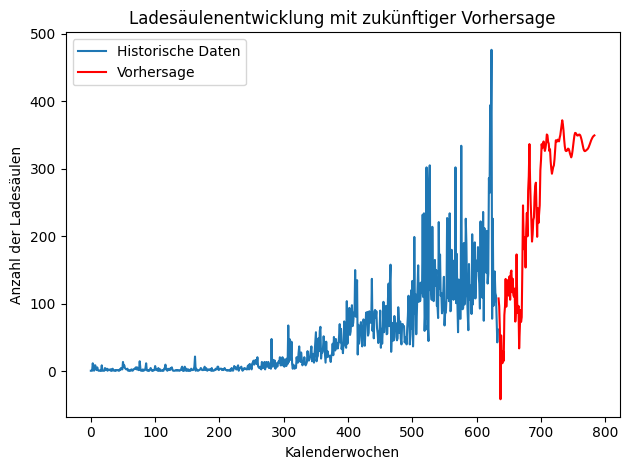

In [258]:
# Füge die zukünftigen Vorhersagen dem ursprünglichen DataFrame hinzu
neue_tabelle_zukunft = neue_tabelle.append(zukuenftige_vorhersagen_df)

# Visualisiere die historischen Daten und zukünftigen Vorhersagen
plt.plot(neue_tabelle_zukunft.index, neue_tabelle_zukunft['Anzahl'], label='Historische Daten')
plt.plot(zukuenftige_vorhersagen_df.index, zukuenftige_vorhersagen_df['Vorhersage'], label='Vorhersage', linestyle='solid', color='red')      #dashed funktioniert auch
plt.xlabel('Kalenderwochen')
plt.ylabel('Anzahl der Ladesäulen')
plt.title('Ladesäulenentwicklung mit zukünftiger Vorhersage')
plt.legend()
plt.tight_layout()
plt.show()